In [1]:
using CSV, DataFrames, Gadfly, GLM, Distributions

# Chargement des données

In [2]:
data = CSV.read("FF_emissions.csv");
rename!(data, :FF_emissions => :FF)
rename!(data, :LUC_emissions => :LUC)
rename!(data, :ocean_sink => :Ocean)
rename!(data, :land_sink => :Land)
rename!(data, :T_anomaly => :T)
data[:Ocean] = -data[:Ocean]
data[:Land] = -data[:Land]
head(data)




,Year,FF,LUC,Ocean,Land,T
1,1959,2.45,1.47,-0.92,-0.97,0.08
2,1960,2.57,1.46,-0.93,-1.59,0.08
3,1961,2.58,1.53,-0.8,-1.65,0.15
4,1962,2.69,1.52,-0.87,-2.15,0.06
5,1963,2.83,1.53,-1.03,-2.12,0.05
6,1964,3.0,1.52,-1.29,-2.19,-0.09


In [3]:
# Construction de matrices pour les données, utiles pour les calculs sans package de régression
X₁ = collect(skipmissing(data[:,:FF]))
X₂ = collect(skipmissing(data[:,:LUC]))
X₃ = collect(skipmissing(data[:,:Ocean]))
X₄ = collect(skipmissing(data[:,:Land]))
Y = collect(skipmissing(data[:,:T]));

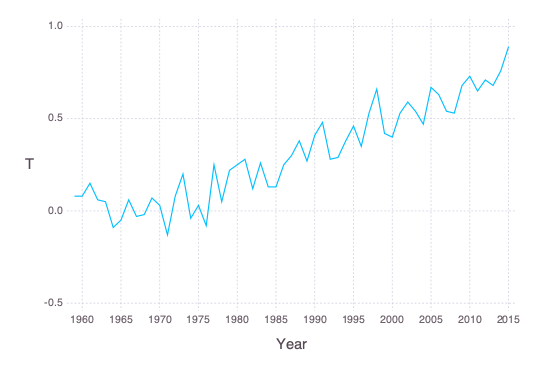

In [4]:
fig1 = plot(data, x=:Year, y=:T, Geom.line, Coord.Cartesian(xmin=1959, xmax=2015), Guide.xticks(ticks=collect(1960:5:2015))) 


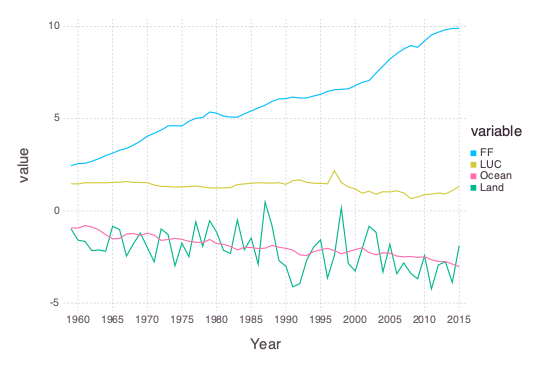

In [5]:
fig2 = plot(stack(data, [:FF, :LUC, :Ocean, :Land]), x=:Year, y=:value, color=:variable, Geom.line, Coord.Cartesian(xmin=1959, xmax=2015), Guide.xticks(ticks=collect(1960:5:2015)) )


# Modèle de régression linéaire multiple

Pour commencer, on utilise seulement les émissions par combustion de combustibles fossibles 
comme variable explicative.

## 4.2 Estimation des paramètres du modèle de régression

β̂ = [-0.357433, 0.113168]


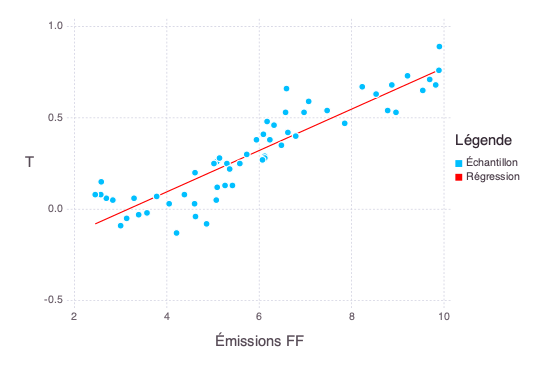

In [17]:
#4.2.1 Estimation des coefficients de régression

# taille de l'échantillon
n = length(Y)

# Inclure une colonne de 1 dans la matrice des variables explicatives
X = [ones(n) X₁]

# Estimation des paramètres par la méthode des moindres carrés
β̂ = (X'*X)\X'*Y
println("β̂ = $β̂")

sample = layer( x=X[:,2], y=Y, Geom.point, Theme(default_color="deepskyblue"))
xx = [ones(10) collect(linspace(minimum(X₁),maximum(X₁),10))]
regression = layer(x=xx[:,2], y = xx*β̂, Geom.line, Theme(default_color="red"))

plot(sample,regression ,
    Guide.manual_color_key("Légende", ["Échantillon", "Régression"], ["deepskyblue","red"]),
    Coord.Cartesian(xmin=2,xmax=10), Guide.xlabel("Émissions FF"), Guide.ylabel("T"))


In [7]:
# 4.2.2 Estimation de la variance de l'erreur

# Nb de variables explicatives
p = size(X,2)-1

# Calcul des résidus
e = Y-X*β̂

# Estimation de la variance de l'erreur
σ̂² = 1/(n-p-1)*sum( e.^2 )
println("σ̂² = $σ̂²")


σ̂² = 0.011989231256904855


In [8]:
# 4.2.3 Prévision de Y pour un x donné

# Si en 2020 on émet 8 Gt C, quelle est l'anomalie de température attendue ? 

# L'estimation ponctuelle est la suivante
x₀ = [1 8]
Ŷ₀ = x₀*β̂
println("Si on émet 8 Gt C, on s'attend à une anomalie de température de $Ŷ₀")


Si on émet 8 Gt C, on s'attend à une anomalie de température de [0.547915]


## 4.3 Validation des hypothèses de la régression

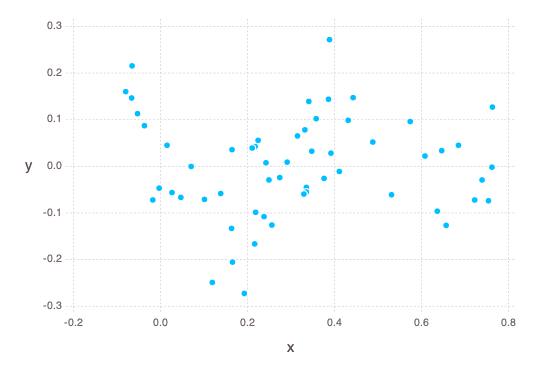

In [9]:
#= Ici, puisque nous somme dans le cas de la régression linéaire simple, 
on peut superposer le nuage de poaint à la droite de régression comme on l'a fait à la 
section précédente. Toutefois, nous examinerons les résidus de la régression, qui la méthode
plus générale pour la régression linéaire multiple. =#

Ŷ = X*β̂
e = Y - Ŷ
plot(x=Ŷ, y=e, Geom.point)

#= Ici les résidus sont centrés autour de 0 et semble avoir une variance plutôt constante.
    Toutefois, la forme des résidus est un peu embêtante, on aimerait avoir une forme plus
    rectangulaire. On verra plus tard si l'ajout de variables explicatives améliore permet
    d'obtenir ce rectangle. =#

## 4.6 Tests d'hypothèses et intervalles de confiance

On utilise le seuil de 5% par défaut.

In [10]:
# 4.6.1 Est-ce que la régression avec X₁ est significative ?

SST = sum( (Y-mean(Y)).^2)
SSE = sum( (Y-X*β̂).^2 )
SSR = SST - SSE

F₀ = (SSR/1) / (SSE/(n-1-1)) 

# On rejette H₀ au seuil de 5% si la valeur-p associé à F₀ est plus petite que 5%
valeurp = ccdf(FDist(1,55),F₀)
println("Comme la valeur-p = $valeurp<0.05, on rejette H_0.")
println("La régression est donc significative.")

# Calcul du coefficient de détermination
R² = SSR/SST
println("Le coefficient de détermination est $R²")

Comme la valeur-p = 1.0142150090924611e-22<0.05, on rejette H_0.
La régression est donc significative.
Le coefficient de détermination est 0.8285745039364913


In [11]:
# 4.6.2 Intervalles de confiance sur les coefficients de régression

C = inv(X'*X)
t = quantile(TDist(n-p-1),.975)

IC = [β̂-t*sqrt.(σ̂²*diag(C)) β̂+t*sqrt.(σ̂²*diag(C))]

println("β̂₀ = $(β̂[1]), $(IC[1,:])")
println("β̂₁ = $(β̂[2]), $(IC[2,:])")

β̂₀ = -0.3574329447398654, [-0.444323, -0.270542]
β̂₁ = 0.11316846326977295, [0.0992586, 0.127078]


In [12]:
# 4.6.3 Intervalle de confiance sur la prévision

# Si en 2020 on émet 8 Gt C, quelle est l'anomalie de température attendue ? 

# L'estimation ponctuelle est la suivante
x₀ = [1 8]
Ŷ₀ = x₀*β̂

t = quantile(TDist(n-p-1),.975)

IC = [Ŷ₀-t*sqrt.(σ̂²*(1+x₀/(X'*X)*x₀')) Ŷ₀+t*sqrt.(σ̂²*(1+x₀/(X'*X)*x₀'))]

println("Si on émet 8 Gt C, on s'attend à une anomalie de température de $Ŷ₀, $IC.")


Si on émet 8 Gt C, on s'attend à une anomalie de température de [0.547915], [0.324622 0.771208].


## On peut reproduire tous les résultats avec le package GLM

In [13]:
# Estimons les paramètres du modèle avec le package GLM

M₁ = lm(@formula(T ~ FF), data)
x₀ = [1 8]
Ŷ₀ = predict(M₁,x₀)
println("Si on émet 8 Gt C, on s'attend à une anomalie de température de $Ŷ₀")
e = residuals(M₁)
R² = 1 - sum(e.^2)/SST
println("Le coefficient de détermination est $R²")

Si on émet 8 Gt C, on s'attend à une anomalie de température de [0.547915]
Le coefficient de détermination est 0.8285745039364913


# 4.7 Comparaison de modèles (Partie 1)

Dans cette première partie, tentons de trouver la variable expicative qui a le plus grand pouvoir prédictif sur Y. On doit donc comparer 4 modèles de régression linéaire simple. Nous les comparerons avec le coefficient de détermination et le coefficient de détermination.

In [14]:
M₁ = lm(@formula(T ~ FF), data)
M₂ = lm(@formula(T ~ LUC), data)
M₃ = lm(@formula(T ~ Ocean), data)
M₄ = lm(@formula(T ~ Land), data)

R² = zeros(4);

e = residuals(M₁)
R²[1] =  1 - sum(e.^2)/SST
e = residuals(M₂)
R²[2] =  1 - sum(e.^2)/SST
e = residuals(M₃)
R²[3] =  1 - sum(e.^2)/SST
e = residuals(M₄)
R²[4] =  1 - sum(e.^2)/SST

m = findmax(R²)
println("Le meilleur modèle est le modèle $(m[2]) avec un R² de $(m[1])")

Le meilleur modèle est le modèle 1 avec un R² de 0.8285745039364913


# 4.7 Comparaison de modèles (Partie 2)

Dans cette première partie, tentons de trouver les variables explicatives qui ont le meilleur pouvoir prédictif sur Y. On doit comparer une collection de modèles de différentes dimensions avec le coefficient de détermination ajusté.

In [15]:
M₁ = lm(@formula(T ~ FF), data)
M₂ = lm(@formula(T ~ FF + Ocean), data)
M₃ = lm(@formula(T ~ FF + Ocean + LUC), data)
M₄ = lm(@formula(T ~ FF + Ocean + LUC + Land), data)

R² = zeros(4);

# Pour le modèle M₁
p = length(coef(M₁))-1
e = residuals(M₁)
SSE = sum(e.^2)
R²[1] =  1 - SSE/SST * (n-1)/(n-p)

# Pour le modèle M₂
p = length(coef(M₂))-1
e = residuals(M₂)
SSE = sum(e.^2)
R²[2] =  1 - SSE/SST * (n-1)/(n-p)

# Pour le modèle M₃
p = length(coef(M₃))-1
e = residuals(M₃)
SSE = sum(e.^2)
R²[3] =  1 - SSE/SST * (n-1)/(n-p)

# Pour le modèle M₄
p = length(coef(M₄))-1
e = residuals(M₄)
SSE = sum(e.^2)
R²[4] =  1 - SSE/SST * (n-1)/(n-p)

m = findmax(R²)
println("Le meilleur modèle est le modèle $(m[2]) avec un R² ajusté de $(m[1])")


Le meilleur modèle est le modèle 4 avec un R² ajusté de 0.8580225155320451


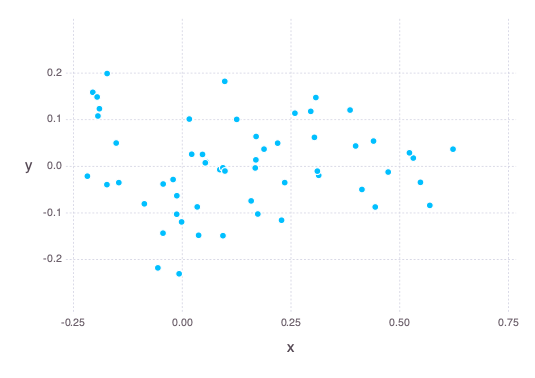

In [16]:
# Analyse des résidus du meilleur modèle trouvé à la section précédente

X = [ones(n) X₁ X₂ X₃ X₄]
Ŷ = predict(M₄,X)
e = residuals(M₄)

plot(x=Ŷ, y=e, Geom.point, Coord.Cartesian(ymin=-.3,ymax=.3))